1. [**Исследование данных**](#preprocessing)
    * [Знакомство с данными](#meet)
    * [Пропущенные значения, типы данных и дубликаты](#type_data)
1. [**Метрики**](#metrics)
    * [Пользовательская активность](#activeness)
        * [Количество пользователей в день](#num_day)
        * [Количество пользователей в неделю](#num_week)
        * [Количество пользователей в месяц](#num_month)
        * [Количество сессий в день](#num_sessions)
        * [Длительность сессии](#duration_sessions)
        * [Как часто пользователи возвращаются](#frequency)
    * [Покупки](#purchases)
        * [Начало покупок](#start_purchases)
        * [Количество покупок за период](#num_purchases)
        * [Средний чек](#avg_check)
        * [LTV](#ltv)
    * [Затраты](#costs)
        * [Деньги на маркетинг](#marketing)
        * [Привлечение покупателей](#attraction)
        * [Чистая прибыль](#profit)
1. [**Выводы**](#summary)

<a id="preprocessing"></a>
# **Исследование данных**

In [1]:
#!pip install pandasql

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
from datetime import timedelta, date, datetime
import pandasql as ps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import calendar

In [3]:
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
# чтобы отображались все столбцы, е ли их будет много
pd.set_option('display.max_columns', None)

<a id="meet"></a>
## Знакомство с данными

In [4]:
# автоматизируем процесс открытия данных
path_list = ['../datasets/visits_log.csv',
             '../datasets/orders_log.csv',
             '../datasets/costs.csv']
visits, orders, costs = (
    [pd.read_csv(p) for p in path_list]
)
df_list = [visits, orders, costs]

In [5]:
# оценим размеры данных и посмотрим на первые строки данных
for d, p in zip(df_list, path_list):
    print ('Size of {}: {}'.format(p[9:], d.shape))
    display(HTML(d.head(3).to_html()))

Size of ts/visits_log.csv: (358532, 5)


Size of ts/orders_log.csv: (50415, 3)


Size of ts/costs.csv: (2542, 3)


<a id="type_data"></a>
## Пропущенные значения, типы данных и дубликаты

In [6]:
def isnull_percent(data, text):
    print ('Доля пропущенных значений '+text+':')
    print ((data.isnull().sum() / data.shape[0]).apply('{:.2%}'.format))

In [7]:
# автоматизируем вывод долей пропущенных значений
name_df_list = ['visits', 'orders', 'costs']
for d, p in zip(df_list, name_df_list):
    isnull_percent(d, p)
    print ()

Доля пропущенных значений visits:
Uid          0.00%
Device       0.00%
End Ts       0.00%
Source Id    0.00%
Start Ts     0.00%
dtype: object

Доля пропущенных значений orders:
Buy Ts     0.00%
Revenue    0.00%
Uid        0.00%
dtype: object

Доля пропущенных значений costs:
source_id    0.00%
dt           0.00%
costs        0.00%
dtype: object



Пропусков нет, проверим типы данных.

In [8]:
for d, p in zip(df_list, name_df_list):
    print (p+':')
    print (d.info())
    print ()

visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

costs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



Приведём даты в формат даты. Остальные данные в порядке.

In [9]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Так как данные собраны автоматически из логов, дубликатов быть не может.

<a id="metrics"></a>
# **Метрики**

Посмотрим на данные повнимательнее.

In [10]:
print ('Количество сессий, которые длятся больше суток:',
       visits.loc[(visits['End Ts'] - visits['Start Ts']).dt.days > 1]['Uid'].count())
print ('Количество сессий, которые начались позже, чем закончились:',
       visits.loc[visits['End Ts'] < visits['Start Ts']]['Uid'].count())
print ('Количество сессий, для которых совпадают время начала и время окончания:',
       visits.loc[visits['End Ts'] == visits['Start Ts']]['Uid'].count())

Количество сессий, которые длятся больше суток: 876
Количество сессий, которые начались позже, чем закончились: 144
Количество сессий, для которых совпадают время начала и время окончания: 35794


In [11]:
print ('{:.2%} сессий начались позже, чем закончились'
       .format(visits.loc[visits['End Ts'] < visits['Start Ts']]['Uid'].count() /
               visits['Uid'].count()))
print ('{:.2%} сессий имеют нулевую длительность'
       .format(visits.loc[visits['End Ts'] == visits['Start Ts']]['Uid'].count() /
               visits['Uid'].count()))

0.04% сессий начались позже, чем закончились
9.98% сессий имеют нулевую длительность


Сессии, которые начались позже, чем закончились и сессии нулевой длительности - скорее всего ошибки. Вряд ли кто-то успел что-то купить за это время.  
Проверим, были ли у пользователей, совершающих такие сессии, другие сессии.  
А также проверим, есть ли у них покупки.

In [12]:
# пользователи, совершающие странные сессии
users_strange = visits.loc[visits['End Ts'] <= visits['Start Ts']]['Uid'].unique()
# пользователи, совершившие покупки
users_orders = orders['Uid'].unique()
# пользователи, совершающие нормальные сессии
users_norm = visits.loc[visits['End Ts'] > visits['Start Ts']]['Uid'].unique()
# странные, совершающие нормальные сессии и совершившие покупки
count_users_norm_order = 0
for row in users_strange:
    if row in users_norm and row in users_orders:
        count_users_norm_order += 1
# странные, совершившие покупки, но не совершающие нормальных сессий
count_users_notnorm = 0
for row in users_strange:
    if row not in users_norm and row in users_orders:
        count_users_notnorm += 1
print ('Существует', len(users_strange), 'пользователей, совершающих странные сессии.')
print ('Из них', count_users_norm_order, 'пользователей совершали нормальные сессии и что-то покупали.')
print (count_users_notnorm, 'пользователя не совершали нормальных сессий, но совершали покупки.')

Существует 32940 пользователей, совершающих странные сессии.
Из них 3808 пользователей совершали нормальные сессии и что-то покупали.
492 пользователя не совершали нормальных сессий, но совершали покупки.


У пользователей, которые совершали нулевые и отрицательные сессии были и сессии с положительной длительностью, и покупки они совершали.  
Значит удалять эти "странные" сессии нельзя.

Но из-за них будет трудно понять порядок всех сессий каждого пользователя и определить в какую из сессий были совершены покупки.  
Возможно, произошёл какой-то сбой, из-за которого время начала и время конца сессии записалось "не туда".  
Оставим сессии нулевой длительности как есть, а для сессий, которые начались позже, чем закончились, поменяем даты местами.

In [13]:
visits['temp_start'] = visits['End Ts'].where(visits['Start Ts'] >= visits['End Ts'], visits['Start Ts'])
visits['temp_end'] = visits['Start Ts'].where(visits['Start Ts'] >= visits['End Ts'], visits['End Ts'])
visits['Start Ts'] = visits['temp_start']
visits['End Ts'] = visits['temp_end']
del visits['temp_start']
del visits['temp_end']

Выставим порядок сессий для каждого пользователя и добавим столбец с датой его первой сессии.

In [14]:
cumcount = visits.sort_values(['Uid', 'Start Ts']).groupby('Uid').cumcount()
visits = pd.concat([visits,cumcount],axis=1)
visits.rename(columns = {0:'cumcount'}, inplace = True)

In [15]:
visits['first_session'] = visits['Start Ts'].where(visits['cumcount'] == 0, '')
dict_first_session = dict(zip(visits.query('first_session != ""')['Uid'],visits.query('first_session != ""')['first_session']))
visits['first_session'] = visits['Uid'].map(dict_first_session)

In [16]:
visits.sort_values(['Uid', 'Start Ts']).head(8)

Uid   Device              End Ts  Source Id  \
196543   11863502262781    touch 2018-01-03 17:33:00          3   
257333   49537067089222    touch 2018-06-02 15:57:00          2   
173818  297729379853735  desktop 2017-07-06 18:48:00          3   
173142  313578113262317  desktop 2017-09-18 23:07:00          2   
192554  313578113262317  desktop 2018-02-18 15:26:00          2   
113873  313578113262317  desktop 2018-11-03 17:29:00          2   
34588   325320750514679  desktop 2017-09-30 14:38:00          5   
41778   325320750514679  desktop 2018-02-26 12:34:00          5   

                  Start Ts  cumcount       first_session  
196543 2018-01-03 17:27:00         0 2018-01-03 17:27:00  
257333 2018-06-02 15:55:00         0 2018-06-02 15:55:00  
173818 2017-07-06 18:47:00         0 2017-07-06 18:47:00  
173142 2017-09-18 22:49:00         0 2017-09-18 22:49:00  
192554 2018-02-18 15:17:00         1 2017-09-18 22:49:00  
113873 2018-11-03 17:23:00         2 2017-09-18 22:49:00  
34588  2017-09-30 14:29:00         0 2017-09-30 14:29:00  
41778  2018-02-26 12:33:00         1 2017-09-30 14:29:00

Создадим несколько вспомогательных столбцов с номерами недель и месяцев.

In [17]:
visits['session_date'] = visits['Start Ts'].dt.date
visits['session_end_date'] = visits['End Ts'].dt.date
visits['session_week'] = visits['Start Ts'].dt.week
visits['session_month'] = visits['Start Ts'].dt.month
visits['session_year'] = visits['Start Ts'].dt.year

<a id="activeness"></a>
## Пользовательская активность

Оценки пользовательской активности:
- DAU (от англ. daily active users) — количество уникальных пользователей в день
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц

In [18]:
dau = visits.groupby('session_date').agg({'Uid': 'nunique'}).mean()
wau = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()
mau = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()

In [19]:
print ('Количество уникальных пользователей в день:', dau['Uid'])
print ('Количество уникальных пользователей в неделю:', wau['Uid'])
print ('Количество уникальных пользователей в месяц:', mau['Uid'])

Количество уникальных пользователей в день: 905.5013698630137
Количество уникальных пользователей в неделю: 4386.802816901409
Количество уникальных пользователей в месяц: 12300.958333333334


Но эти оценки не подойдут для ответа на вопрос "сколько пользователей в день/неделю/месяц", так как сессии некоторых пользователей длятся дольше одного дня и интересно общее количество, а не только те, кто подключился в исследуемый период. Посчитаем именно количество пользователей и количество новых пользователей из них для каждого промежутка времени (день, неделя, месяц).

-----

<span style="color:red">
    
***`range_data()` ооочень медленно работает =(***

Если бы были данные за несколько лет, это было бы совсем ужасно (

Но если группировать, а не записывать каждую строку оттдельно, то не получится записать сколько новых пользователей появилось конкретно в этот период..

</span>

-----

In [20]:
def range_data(n):
    count_of_range = pd.DataFrame(columns = ['moment', 'name_range', 'total', 'uniq', 'session',
                                             'start_range', 'end_range',
                                             'desktop', 'desktop_uniq', 'desktop_session',
                                             'touch', 'touch_uniq', 'touch_session',
                                             'source_1', 'source_2', 'source_3', 'source_4',
                                             'source_5', 'source_6', 'source_7', 'source_8',
                                             'source_9', 'source_10'])
    
    sources = visits['Source Id'].unique()
    uniq_uid = visits['Uid'].unique()
    start = visits['session_date'].min()
    end = visits['session_end_date'].max()
    step = timedelta (days = n)
    
    i = 0
    while start <= end:
        
        if n == 1:
            name = str(start)
            moment = start
            end_r = start
        elif n == 7:
            end_r = start + timedelta(days = 6 - start.weekday(), weeks = 1)
            name = str(start.isocalendar()[1]) + ': ' + str(start) + ' - ' + str(end_r)
            moment = start.isocalendar()[1]
        else:
            start = start.replace(day = 1)
            end_r = start.replace(day = calendar.monthrange(start.year, start.month)[1])
            name = str(start.strftime("%B"))+' '+str(start.year)
            moment = start.month
    
        data_query = (
            visits.query('session_date <= @start and session_end_date >= @start or session_date >= @start and session_end_date <= @end_r or session_date <= @end_r and session_end_date >= @end_r')
        )
        
        # количество пользователей, чьи сессии были активны в этот день
        total = data_query['Uid'].unique()
        # количество активных сессий
        session = data_query['Uid']
        # количество пользователей с компьютера
        desktop = data_query.query('Device == "desktop"')['Uid'].unique()
        # количество пользователей с телефона
        touch = data_query.query('Device == "touch"')['Uid'].unique()
        # количество сессий с компьютера
        desktop_session = data_query.query('Device == "desktop"')['Uid']
        # количество сессий с телефона
        touch_session = data_query.query('Device == "touch"')['Uid']
        # количество пользователей из каждого ресурса
        source_count = [0] * (max(sources) + 1)
        data_query.rename(columns = {'Source Id':'source_id'}, inplace = True)
        for row in sources:
            source_count[row] = data_query.query('source_id == @row')['Uid'].nunique()
        # количество новых пользователей, появившихся в этот день
        uniq = data_query.query('Uid in @uniq_uid')['Uid'].unique()
        # количество пользователей с компьютера
        desktop_u = data_query.query('Device == "desktop" and Uid in @uniq_uid')['Uid'].unique()
        # количество пользователей с телефона
        touch_u = data_query.query('Device == "touch" and Uid in @uniq_uid')['Uid'].unique()
        # убираем этих пользователей из списка новых
        for row in uniq:
            uniq_uid = np.delete(uniq_uid, np.argwhere(uniq_uid == row))
        
        count_of_range.loc[i] = [moment, name, len(total), len(uniq), session.count(), start, end_r,
                                 len(desktop), len(desktop_u), desktop_session.count(),
                                 len(touch), len(touch_u), touch_session.count(),
                                 source_count[1], source_count[2], source_count[3],
                                 source_count[4], source_count[5], source_count[6], source_count[7],
                                 source_count[8], source_count[9], source_count[10]]
        
        if n <= 7:
            start += step
        else:
            start += timedelta(days = calendar.monthrange(start.year, start.month)[1])
        
        i += 1
    return count_of_range

In [21]:
# считаем количество "зон" для графика (чтобы месяцы наглядно разделялись)
n_months = ((visits['session_end_date'].max().year - visits['session_date'].min().year) * 12 +
            + visits['session_end_date'].max().month - visits['session_date'].min().month) + 1

# записываем диапазоны дат по меясцам (с начала до конца месяца - одна "зона" графика)
date_range = []
date_start = visits['session_date'].min()
for month in range(n_months):
    date_end = date(date_start.year, date_start.month, calendar.monthrange(date_start.year,date_start.month)[1])
    date_range.append([date_start, date_end])
    date_start = date_end + timedelta(days = 1)

In [22]:
def barplot_range(data, n, text_title, text_file, size_x, size_y):
    sns.axes_style("whitegrid")
    fig, ax = plt.subplots(figsize = (size_x, size_y))
    # в зависимости от чётности "зоны" окрашиваем график в нужный цвет
    clrs = []
    if n == 7:
        week_start = count_of_week.loc[0, 'start_range'].isocalendar()[1]
    i = 0
    for row in range(n_months):
        if row % 2 == 0:
            color = 'b'
        else:
            color = 'm'
        if n == 1:
            date_start = date_range[row][0]
            date_end = date_range[row][1]
            for j in range(len(count_of_day.query('moment >= @date_start and moment <= @date_end'))):
                clrs.append(color)
        elif n == 7:
            while (count_of_week.loc[i, 'end_range'].month == count_of_week.loc[i + 1, 'end_range'].month and i < count_of_week.shape[0] - 2):
                clrs.append(color)
                i += 1
            i += 1
            week_end = count_of_week.loc[i - 1, 'end_range'].isocalendar()[1]
            week_start = week_end + 1
        if n > 1:
            clrs.append(color)
    if n > 1:
        clrs.append(color)
    
    sns.set_color_codes('pastel')
    sns.barplot(y = 'name_range', x = 'total', data = data, palette = clrs)
    
    sns.set_color_codes('muted')
    sns.barplot(y = 'name_range', x = 'uniq', data = data, palette = clrs)
    
    if n == 1:
        # чтобы подписи не склеивались, подписываем первую и последнюю даты и первое число каждого месяца
        ys = range(len(count_of_day['moment']))
        y_ticks = []
        y_ticks.append(count_of_day.loc[0, 'moment'].strftime('%d-%m-%Y'))
        for i in range(1, len(count_of_day['moment']) - 2):
            if count_of_day.loc[i, 'moment'].month > count_of_day.loc[i - 1, 'moment'].month or (count_of_day.loc[i, 'moment'].month == 1 and count_of_day.loc[i - 1, 'moment'].month == 12):
                y_ticks.append(count_of_day.loc[i, 'moment'].strftime('%d-%m-%Y'))
            else:
                y_ticks.append('')
        y_ticks.append(count_of_day.loc[len(count_of_day['moment']) - 1, 'moment'].strftime('%d-%m-%Y'))
    
        plt.yticks(ys, y_ticks)
        ax.set_yticklabels(labels = y_ticks)
    
    # параметры легенды и названия графика
    legend_labels  = ['Все пользователи', 'Уникальные пользователи', 'Все пользователи', 'Уникальные пользователи']
    colors = ['#a2caf4', 'b', '#fab2e5', 'm']
    legend_patches = [matplotlib.patches.Patch(color = C, label = L) for
                      C, L in zip(colors, legend_labels)]
    ax.legend(ncol = 1, loc = 'upper right', frameon = True, handles = legend_patches)
    ax.set(ylabel = '', xlabel = '')
    plt.title('Количество пользователей в '+text_title, fontsize = 16, loc = 'left')
    
    plt.savefig('images/'+text_file+'.png', bbox_inches = 'tight')
    
    sns.despine(left = True, bottom = True)

In [23]:
visits_touch = visits.query('Device == "touch"')
visits_desktop = visits.query('Device == "desktop"')

<a id="num_day"></a>
### Количество пользователей в день

In [24]:
count_of_day = range_data(1)

D:\Users\owl11\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [25]:
count_of_day.head(3)

moment  name_range total uniq session start_range   end_range desktop  \
0  2017-01-06  2017-01-06   605  605     661  2017-01-06  2017-01-06     455   
1  2017-01-07  2017-01-07   370  359     398  2017-01-07  2017-01-07     228   
2  2017-01-08  2017-01-08   426  404     453  2017-01-08  2017-01-08     329   

  desktop_uniq desktop_session touch touch_uniq touch_session source_1  \
0          455             499   153        153           162       59   
1          220             247   143        140           151       26   
2          314             351    98         91           102       36   

  source_2 source_3 source_4 source_5 source_6 source_7 source_8 source_9  \
0       79      182      138      114        0        0        0       51   
1       49       77       70      146        1        0        0        3   
2       58      110      115       96        0        0        0       17   

  source_10  
0         9  
1         8  
2         7

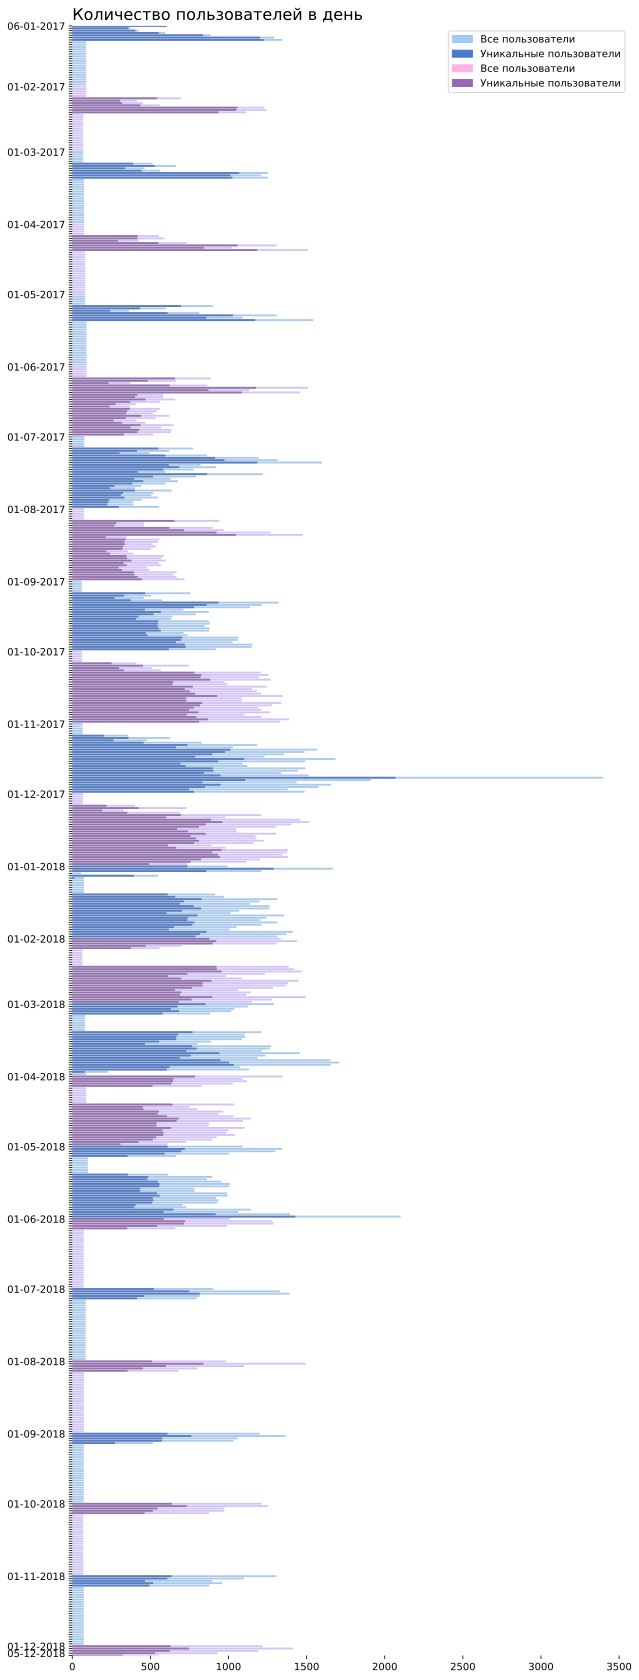

In [26]:
barplot_range(count_of_day, 1, 'день', 'count_of_day', 10, 30)

Красиво, но экран маловат.. Возможно, тепловая карта будет удобнее.

In [27]:
count_of_day['n_month'] = count_of_day['moment'].apply(lambda x: date(x.year, x.month, 1))
count_of_day['n_day'] = count_of_day['moment'].apply(lambda x: x.day)
count_of_day = count_of_day.sort_values(['n_day', 'n_month'])
month_day_pivot = count_of_day.pivot_table(index = 'n_month', columns = 'n_day', values = 'total', aggfunc = 'sum')

In [28]:
def heatmap_count(data, size_x, size_y, text_title, text_file):
    fig, (ax, cax) = plt.subplots(nrows = 2, figsize = (size_x, size_y),  gridspec_kw = {"height_ratios":[1, 0.025]})
    annot_kws = {'fontsize': 8, 'verticalalignment': 'center'}
    
    sns.heatmap(data, annot = True, fmt = '.0f', annot_kws = annot_kws,
                linewidths = 1, linecolor = 'gray', cmap = "PuRd", cbar = False, ax = ax)
    
    fig.colorbar(ax.get_children()[0], cax = cax, orientation = "horizontal")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 1, top - 1)
    
    ax.set_ylabel('Месяц')
    ax.set_xlabel('День')
    ax.set_title('Количество '+text_title, fontsize = 15, loc = 'left')
    
    plt.savefig('images/'+text_file+'_heatmap.png', bbox_inches = 'tight')
    
    plt.show()

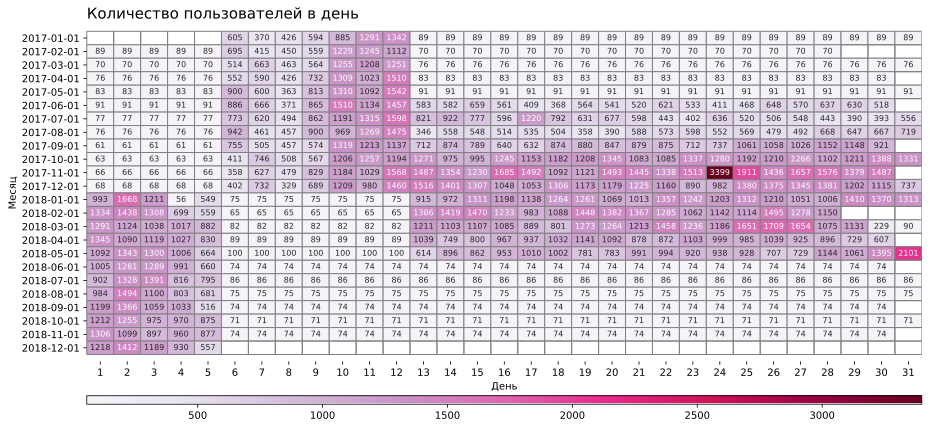

In [29]:
heatmap_count(month_day_pivot, 15, 7, 'пользователей в день', 'count_of_day')

Больше всего пользователей находились на сайте 24-11-2017. Возможно, люди за месяц начали искать новогодние мероприятия, в том числе ёлки для детей, которые могут проходить в декабре и брать билеты надо заранее. В конце ноября 2018 ничего такого не наблюдается, что странно.  
В целом получается, что по этим данным невозможно предположить поведение людей исходя из времени. Много людей с июня 2017 по июнь 2018 в принципе: если бы это было связано с какими-то ежегодными событиями, например, театральным сезоном, то было бы два "всплеска" за два года, а не то, что мы видим.

Хотелось бы посмотреть на тепловые карты для разных устройств по отдельности, но опять-таки экран маловат, чтобы поставить их рядом и сравнить. Лучше сразу посмотреть на усреднённые цифры.

In [30]:
d = {"total":pd.Series([count_of_day['total'].mean(), count_of_day['touch'].mean(),
                        count_of_day['desktop'].mean()], index = ['all', 'touch', 'desktop']),
     "uniq": pd.Series([count_of_day['uniq'].mean(), count_of_day['touch_uniq'].mean(),
                        count_of_day['desktop_uniq'].mean()], index = ['all', 'touch', 'desktop'])}
mean_count_of_day = pd.DataFrame(d)

In [31]:
print ('Среднее количество пользователей и среднее количество уникальных пользователей в день')
print ('в общем и для разных устройств:')
mean_count_of_day

Среднее количество пользователей и среднее количество уникальных пользователей в день
в общем и для разных устройств:


total        uniq
all      548.938484  326.422031
touch    151.467811   96.500715
desktop  399.294707  230.693848

В 2017 наибольшее количество людей были на сайте с 6 по 12 числа каждого месяца, а в 2018 - с 1 по 5. Люди в основном пользуются сервисом в первые 10 дней каждого месяца. Скорее всего они выбирают несколько интересных им событий, планируя досуг на весь остаток месяца.  
Так как я не вижу зависимости от дня недели (было бы логично планировать досуг на выходные, например, по понедельникам), праздников, погоды, в общем чего-то повторяемого каждый год, предполагаю, что проходили какие-то акции со скидками, например "купи билет с 5 по 10 января и получи скидку".  

Возможно, в июне 2017 прошла какая-то рекламная компания, которая увеличила приток пользователей, или вышло приложение для смартфонов, или в приложении или на сайте произошли существенные изменения, повысившие удобство пользования, и с началом 2018 года люди стали планировать досуг на ближайший месяц в первых числах. Но к июню 2018 интерес спал. Возможно, снова были привнесены какие-то новшества, которые оказались неудобными.


Больше всего новых пользователей возникает примерно на 10-15 день каждого месяца. А после этих чисел до июня 2017 и после июня 2018 новых пользователей не появлялось вообще.  

Позже посмотрим на данные о покупках: возможно, часть данных о пользователях до июня 2017 и после июня 2018 не учтены.

<a id="num_week"></a>
### Количество пользователей в неделю

In [32]:
count_of_week = range_data(7)

In [33]:
count_of_week.head(3)

moment                  name_range total  uniq session start_range  \
0      1  1: 2017-01-06 - 2017-01-15  5185  5185    5789  2017-01-06   
1      2  2: 2017-01-13 - 2017-01-22    89     0      89  2017-01-13   
2      3  3: 2017-01-20 - 2017-01-29    89     0      89  2017-01-20   

    end_range desktop desktop_uniq desktop_session touch touch_uniq  \
0  2017-01-15    3737         3737            4215  1476       1476   
1  2017-01-22      64            0              64    25          0   
2  2017-01-29      64            0              64    25          0   

  touch_session source_1 source_2 source_3 source_4 source_5 source_6  \
0          1574      418      718     1357     1474     1197        1   
1            25        6        9       20       26       25        0   
2            25        6        9       20       26       25        0   

  source_7 source_8 source_9 source_10  
0        1        0      169       100  
1        0        0        1         2  
2        0        0        1         2

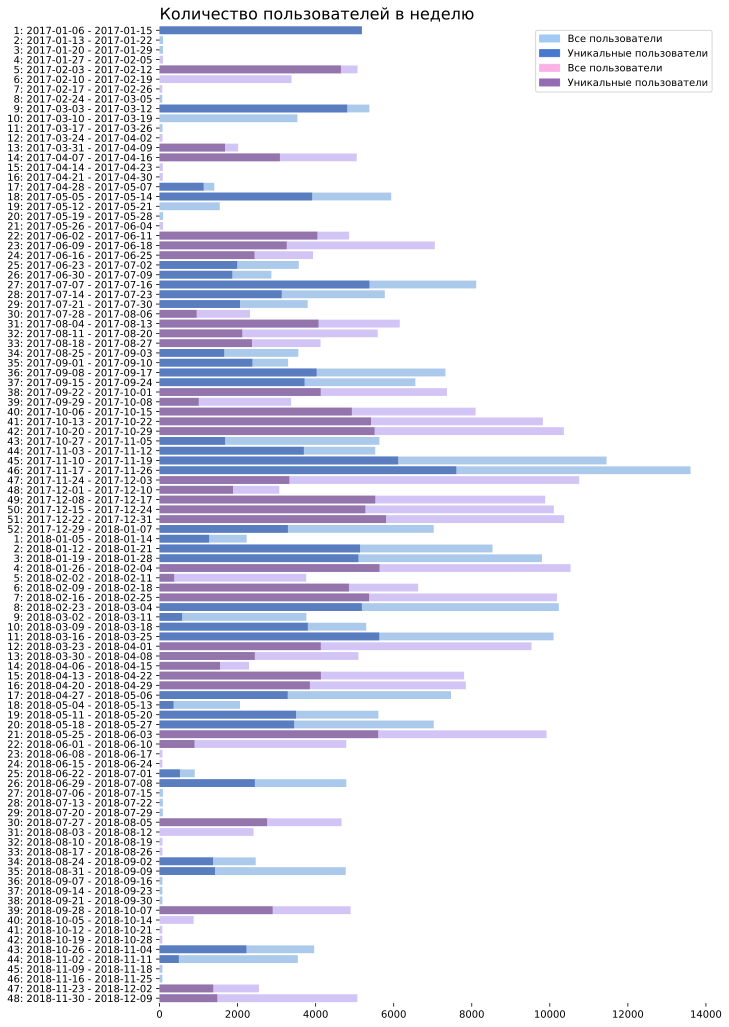

In [34]:
barplot_range(count_of_week, 7, 'неделю', 'count_of_week', 10, 18)

Думаю, здесь тоже будет нагляднее тепловая карта.

In [35]:
def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x == day)[0][0] + 1
    return(week_of_month)

In [36]:
count_of_week['n_month'] = count_of_week['end_range'].apply(lambda x: date(x.year, x.month, 1))
count_of_week['n_week'] = count_of_week['end_range'].apply(lambda x: get_week_of_month(x.year, x.month, x.day))
count_of_week = count_of_week.sort_values(['n_week', 'n_month'])
month_week_pivot = count_of_week.pivot_table(index = 'n_week', columns = 'n_month', values = 'total', aggfunc = 'sum')

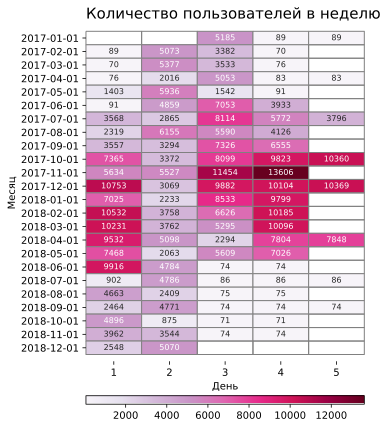

In [37]:
heatmap_count(month_week_pivot.T, 5, 7, 'пользователей в неделю', 'count_of_week')

Данные для разных устройств снова посмотрим численно.

In [38]:
d = {"total":pd.Series([count_of_week['total'].mean(), count_of_week['touch'].mean(),
                        count_of_week['desktop'].mean()], index = ['all', 'touch', 'desktop']),
     "uniq": pd.Series([count_of_week['uniq'].mean(), count_of_week['touch_uniq'].mean(),
                        count_of_week['desktop_uniq'].mean()], index = ['all', 'touch', 'desktop'])}
mean_count_of_week = pd.DataFrame(d)

In [39]:
print ('Среднее количество пользователей и среднее количество уникальных пользователей в неделю')
print ('в общем и для разных устройств:')
mean_count_of_week

Среднее количество пользователей и среднее количество уникальных пользователей в неделю
в общем и для разных устройств:


total     uniq
all      4371.81  2281.69
touch    1273.46   676.75
desktop  3131.80  1614.78

Во вторую неделю месяца стабильно есть достаточное количество пользователей. Скорее всего в этих числах люди получают аванс и планируют куда бы им сходить в этом месяце.  
Ноябрь и декабрь 2017 в целом можно выделить как самые популярные месяцы, но снова остаётся непонятным, что изменилось в 2018.

<a id="num_month"></a>
### Количество пользователей в месяц

In [40]:
count_of_month = range_data(30)

In [41]:
count_of_month.head(3)

moment     name_range total  uniq session start_range   end_range desktop  \
0      1   January 2017  5185  5185    5789  2017-01-01  2017-01-31    3737   
1      2  February 2017  5073  4647    5595  2017-02-01  2017-02-28    3665   
2      3     March 2017  5377  4808    5910  2017-03-01  2017-03-31    3866   

  desktop_uniq desktop_session touch touch_uniq touch_session source_1  \
0         3737            4215  1476       1476          1574      418   
1         3324            4079  1434       1341          1516      402   
2         3423            4283  1538       1401          1627      416   

  source_2 source_3 source_4 source_5 source_6 source_7 source_8 source_9  \
0      718     1357     1474     1197        1        1        0      169   
1      673     1413     1565     1029        0        2        0      108   
2      677     1461     1654     1010        0        1        0      234   

  source_10  
0       100  
1       105  
2       174

In [42]:
count_of_month_desktop = count_of_month.loc[:, ['name_range', 'desktop', 'desktop_uniq']]
count_of_month_touch = count_of_month.loc[:, ['name_range', 'touch', 'touch_uniq']]
count_of_month_touch['device'] = 'touch'
count_of_month_desktop['device'] = 'desktop'
count_of_month_desktop.rename(columns = {'desktop':'total', 'desktop_uniq': 'uniq'}, inplace = True)
count_of_month_touch.rename(columns = {'touch':'total', 'touch_uniq': 'uniq'}, inplace = True)
count_of_month_device = pd.concat([count_of_month_touch, count_of_month_desktop])

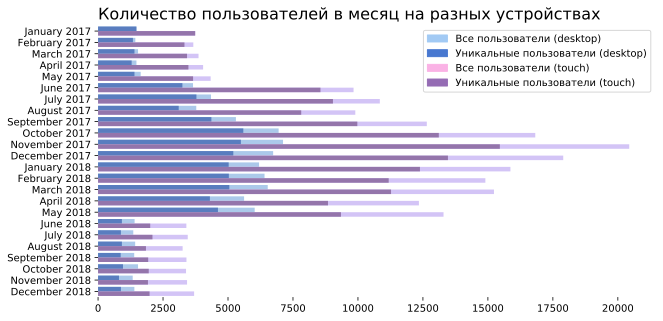

In [43]:
sns.axes_style("whitegrid")
fig, ax = plt.subplots(figsize = (10, 5))

clrs = []
for row in range(n_months):
    if row % 2 == 0:
        color = 'b'
    else:
        color = 'm'
    clrs.append(color)
clrs.append(color)

sns.set_color_codes('pastel')
sns.barplot(y = 'name_range', x = 'total', data = count_of_month_device, hue = 'device', palette = clrs)

sns.set_color_codes('muted')
sns.barplot(y = 'name_range', x = 'uniq', data = count_of_month_device, hue = 'device', palette = clrs)

# параметры легенды и названия графика
legend_labels  = ['Все пользователи (desktop)', 'Уникальные пользователи (desktop)',
                  'Все пользователи (touch)', 'Уникальные пользователи (touch)']
colors = ['#a2caf4', 'b', '#fab2e5', 'm']
legend_patches = [matplotlib.patches.Patch(color = C, label = L) for
                  C, L in zip(colors, legend_labels)]
ax.legend(ncol = 1, loc = 'upper right', frameon = True, handles = legend_patches)
ax.set(ylabel = '', xlabel = '')
plt.title('Количество пользователей в месяц на разных устройствах', fontsize = 16, loc = 'left')

plt.savefig('images/count_of_month_device.png', bbox_inches = 'tight')

sns.despine(left = True, bottom = True)

In [44]:
d = {"total":pd.Series([count_of_month['total'].mean(), count_of_month['touch'].mean(),
                        count_of_month['desktop'].mean()], index = ['all', 'touch', 'desktop']),
     "uniq": pd.Series([count_of_month['uniq'].mean(), count_of_month['touch_uniq'].mean(),
                        count_of_month['desktop_uniq'].mean()], index = ['all', 'touch', 'desktop'])}
mean_count_of_month = pd.DataFrame(d)

In [45]:
print ('Среднее количество пользователей и среднее количество уникальных пользователей в месяц')
print ('в общем и для разных устройств:')
mean_count_of_month

Среднее количество пользователей и среднее количество уникальных пользователей в месяц
в общем и для разных устройств:


total         uniq
all      12360.291667  9507.041667
touch     3586.416667  2831.125000
desktop   8903.208333  6741.583333

Теперь видно, что наибольшее количество пользователей было не по июнь 2018, а по май. Здесь уже можно предполагать влияние театрального сезона, о котором люди в 2017 году подумали заранее (он начинается осенью и длится до весны). Но опять-таки странно, что на следующий театральный сезон (осень 2018 - весна 2019) никто не собрался в театр.  

По всем периодам видно, что с компьютера люди заходят на сайт чаще, чем с телефона. Возможно, мобильная версия сайта не так удобна. А возможно, люди чаще посещают какие-либо культурные мероприятия не в одиночку, из-за чего обсуждать, куда сходить, удобнее с большого монитора компьютера.

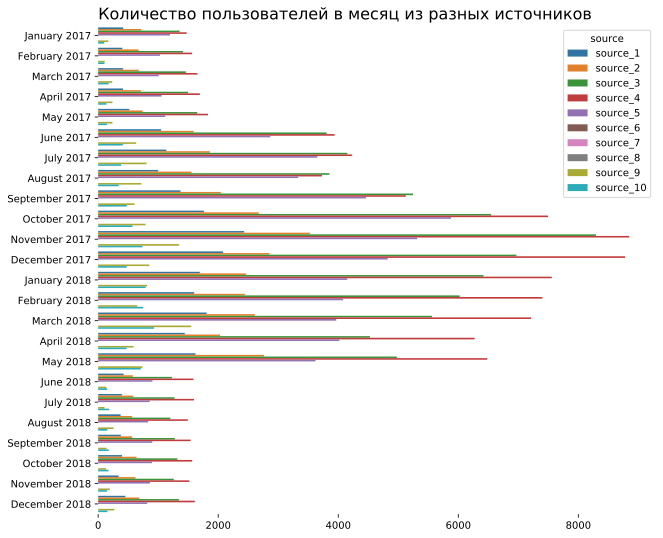

In [46]:
df2 = pd.melt(count_of_month, id_vars = ['name_range'], value_vars = ['source_1', 'source_2', 'source_3', 'source_4',
                                                                      'source_5', 'source_6', 'source_7', 'source_8',
                                                                      'source_9', 'source_10'], var_name = 'source')

sns.axes_style("whitegrid")
fig, ax = plt.subplots(figsize = (10, 9))

sns.set_color_codes('pastel')
sns.barplot(y = 'name_range', x = 'value', data = df2, hue = 'source')

ax.set(ylabel = '', xlabel = '')
plt.title('Количество пользователей в месяц из разных источников', fontsize = 16, loc = 'left')

plt.savefig('images/count_of_month_source.png', bbox_inches = 'tight')

sns.despine(left = True, bottom = True)

В августе и сентябре 2017 из 3 источника было больше всего пользователей, а в остальное время самым "популярным" источником был 4. Что это за источники неизвестно, поэтому предположить, почему так сложилось, невозможно, но по всем месяцам видно, что больше всего пользователей приходят из 3, 4 и 5 источников, а вот на 6, 7 и 8 деньги можно не тратить.

<a id="num_sessions"></a>
### Количество сессий в день

In [47]:
session = visits.groupby(['Uid', 'session_date'])['Start Ts'].count()

Интересны не средние, а наиболее часто встречающиеся показатели, свойственные большинству. Поэтому будем рассчитывать моду.

In [48]:
print ('Большинство пользователей начинают {:.0f} сессию в день.'.format(session.mode().mean()))
print ('В среднем каждый пользователь начинает {:.2f} сессий в день.'.format(session.mean()))
print ('Но существуют пользователи, которые начали {:.0f} сессии в один день.'.format(session.max()))

Большинство пользователей начинают 1 сессию в день.
В среднем каждый пользователь начинает 1.08 сессий в день.
Но существуют пользователи, которые начали 10 сессии в один день.


In [49]:
month_day_session_pivot = count_of_day.pivot_table(index = 'n_month',
                                                   columns = 'n_day',
                                                   values = 'session',
                                                   aggfunc = 'sum')

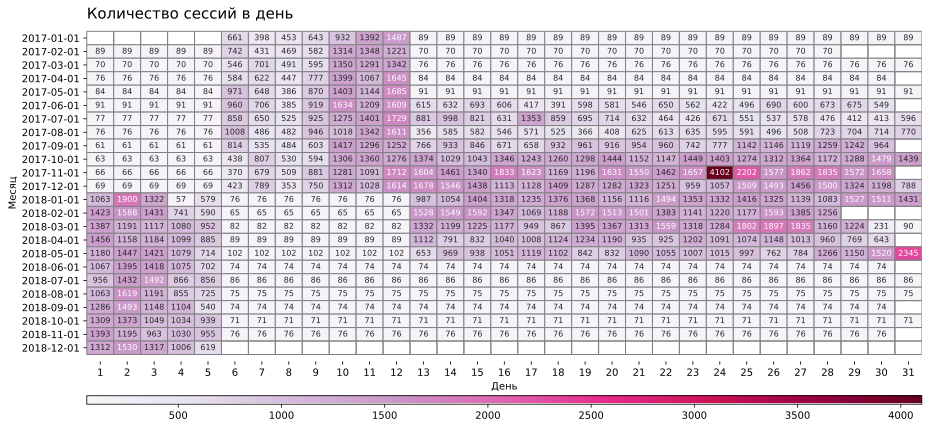

In [50]:
heatmap_count(month_day_session_pivot, 15, 7, 'сессий в день', 'count_session_of_day')

Интересно самое "популярное" количесто сессий, то есть для большинства дней.  
Эту величину показывает мода.

In [51]:
d = {"mean":pd.Series([count_of_day['session'].mean(), count_of_day['touch_session'].mean(),
                        count_of_day['desktop_session'].mean()], index = ['all', 'touch', 'desktop']),
     "mode":pd.Series([count_of_day['session'].mode().mean(), count_of_day['touch_session'].mode().mean(),
                        count_of_day['desktop_session'].mode().mean()], index = ['all', 'touch', 'desktop']),
     "max": pd.Series([count_of_day['session'].max(), count_of_day['touch_session'].max(),
                        count_of_day['desktop_session'].max()], index = ['all', 'touch', 'desktop']),
     "date_max": pd.Series([datetime.strftime(count_of_day[count_of_day['session'] ==
                                               count_of_day['session'].max()]['moment'].iloc[0], '%d/%m/%Y'),
                        datetime.strftime(count_of_day[count_of_day['touch_session'] ==
                                               count_of_day['touch_session'].max()]['moment'].iloc[0], '%d/%m/%Y'),
                        datetime.strftime(count_of_day[count_of_day['desktop_session'] ==
                                               count_of_day['desktop_session'].max()]['moment'].iloc[0], '%d/%m/%Y')],
                       index = ['all', 'touch', 'desktop']),
     "min": pd.Series([count_of_day['session'].min(), count_of_day['touch_session'].min(),
                        count_of_day['desktop_session'].min()], index = ['all', 'touch', 'desktop']),
     "date_min": pd.Series([datetime.strftime(count_of_day[count_of_day['session'] ==
                                               count_of_day['session'].min()]['moment'].iloc[0], '%d/%m/%Y'),
                        datetime.strftime(count_of_day[count_of_day['touch_session'] ==
                                               count_of_day['touch_session'].min()]['moment'].iloc[0], '%d/%m/%Y'),
                        datetime.strftime(count_of_day[count_of_day['desktop_session'] ==
                                               count_of_day['desktop_session'].min()]['moment'].iloc[0], '%d/%m/%Y')],
                       index = ['all', 'touch', 'desktop'])}
session_count_mode = pd.DataFrame(d)

In [52]:
print ('Среднее, наиболее вероятное, максимальное и минимальное количество сессий в день')
print ('в общем и для разных устройств:')
session_count_mode

Среднее, наиболее вероятное, максимальное и минимальное количество сессий в день
в общем и для разных устройств:


mean  mode   max    date_max  min    date_min
all      590.487840  76.0  4102  24/11/2017   57  04/01/2018
touch    158.622318  16.0   902  24/11/2017   13  01/10/2017
desktop  431.865522  62.0  3200  24/11/2017   40  04/01/2018

Как было замечено ранее, наибольшее количество сессий было в конце ноября. Люди понимают, что в новогодние праздники у всех больше времени и загруженность на мероприятиях выше, чем обычно, поэтому ищут билеты заранее.  
Наименьшее количество сессий было 04-01-2018: возможно, чтобы считать, что новогодние праздники прошли не зря, нужно именно 3 дня активного поиска досуга =)  
В среднем, пользователи не начинают больше одной сессии в день. Те, кто начали больше одной сессии в день, скорее всего возвращаются, чтобы приобрести билет, изначально просто поискав мероприятия, на которые хотели бы сходить, либо на компьютере остаётся висеть открытая вкладка, а позже пользователь зашёл с телефона.  

<a id="duration_sessions"></a>
### Длительность сессии

In [53]:
session_duration_sec = (visits['End Ts'] - visits['Start Ts']).dt.seconds
visits = pd.concat([visits,session_duration_sec],axis = 1)
visits.rename(columns = {0:'session_duration_sec'}, inplace = True)

In [54]:
session_duration_sec_touch = (visits_touch['End Ts'] - visits_touch['Start Ts']).dt.seconds
visits_touch = pd.concat([visits_touch,session_duration_sec_touch],axis = 1)
visits_touch.rename(columns = {0:'session_duration_sec'}, inplace = True)

In [55]:
session_duration_sec_desktop = (visits_desktop['End Ts'] - visits_desktop['Start Ts']).dt.seconds
visits_desktop = pd.concat([visits_desktop,session_duration_sec_desktop],axis = 1)
visits_desktop.rename(columns = {0:'session_duration_sec'}, inplace = True)

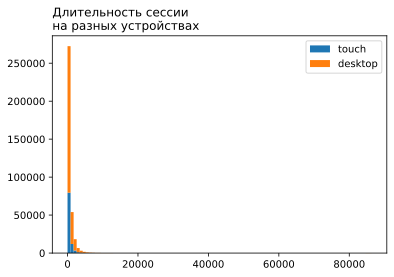

In [56]:
plt.hist([visits_touch['session_duration_sec'], visits_desktop['session_duration_sec']],
         bins = 100, label = ['touch', 'desktop'], stacked = True)
plt.legend(loc = 'upper right')
plt.title('Длительность сессии\nна разных устройствах', loc = 'left')
plt.show()

Длительность сессии на телефона гораздо меньше, чем на компьютерах. Если надолго остаивть открытую вкладку браузера на телефоне в фоновом режиме приложения, то в какой-то момент браузер будет закрыт для высвобождения памяти. Но в основном сессии длятся не очень долго на любых устройствах.

Интересна самая "популярная" продолжительность сессии, то есть время, которое большинство людей проводят на сайте.  
Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Для нашего случая рассчитаем моду.

In [57]:
print('Наиболее частая продолжительность сессии: {:.0f} секунд'.format(visits['session_duration_sec'].mode().mean()))

Наиболее частая продолжительность сессии: 60 секунд


<a id="frequency"></a>
### Как часто пользователи возвращаются

In [58]:
session_by_user = visits.groupby('Uid')['Start Ts'].count()
print ('В среднем каждый пользователь начинал {:.2f} сессий.'.format(session_by_user.mean()))
print ('Но существуют пользователи, которые начали {:.0f} сессии.'.format(session_by_user.max()))
print ('Чаще всего пользователь начинает {:.0f} сессию и больше не возвращается.'.format(session_by_user.mode().mean()))

В среднем каждый пользователь начинал 1.57 сессий.
Но существуют пользователи, которые начали 893 сессии.
Чаще всего пользователь начинает 1 сессию и больше не возвращается.


<a id="purchases"></a>
## Покупки

Соединим таблицы visits и orders по столбцу с идентификатором Uid так, чтобы время покупки было между временем начала и окончания сессии.

In [59]:
# в integer SQLite не влезают Uid, поэтому создадим другие таблицы с Uid в строковом формате
sql_visits = pd.DataFrame()
sql_orders = pd.DataFrame()
sql_visits['start'] = visits['Start Ts']
sql_visits['end'] = visits['End Ts']
sql_visits['uid'] = visits['Uid'].astype(str)
sql_visits['device'] = visits['Device']
sql_visits['source'] = visits['Source Id']
sql_visits['cumcount'] = visits['cumcount']
sql_visits['first_session'] = visits['first_session']
sql_orders['uid'] = orders['Uid'].astype(str)
sql_orders['revenue'] = orders['Revenue']
sql_orders['buy'] = orders['Buy Ts']

sqlcode = '''
    SELECT
        sql_visits.uid,
        sql_visits.first_session,
        sql_visits.start,
        sql_visits.end,
        sql_visits.cumcount,
        sql_orders.buy,
        sql_visits.device,
        sql_visits.source,
        sql_orders.revenue
    FROM
        sql_visits LEFT JOIN sql_orders ON
        (sql_orders.buy BETWEEN sql_visits.start AND sql_visits.end) AND (sql_orders.uid = sql_visits.uid)
    UNION
    SELECT
        sql_orders.uid,
        sql_visits.first_session,
        sql_visits.start,
        sql_visits.end,
        sql_visits.cumcount,
        sql_orders.buy,
        sql_visits.device,
        sql_visits.source,
        sql_orders.revenue
    FROM
        sql_orders LEFT JOIN sql_visits ON
        (sql_orders.buy BETWEEN sql_visits.start AND sql_visits.end) AND (sql_visits.uid = sql_orders.uid)
    '''

visits_orders = ps.sqldf(sqlcode,locals())

In [60]:
# приведём в порядок типы данных visits_orders_left
visits_orders['uid'] = visits_orders['uid'].astype('uint64')
visits_orders['start'] = pd.to_datetime(visits_orders['start'])
visits_orders['end'] = pd.to_datetime(visits_orders['end'])
visits_orders['buy'] = pd.to_datetime(visits_orders['buy'])
visits_orders['first_session'] = pd.to_datetime(visits_orders['first_session'])

In [61]:
visits_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386096 entries, 0 to 386095
Data columns (total 9 columns):
uid              386096 non-null uint64
first_session    358590 non-null datetime64[ns]
start            358590 non-null datetime64[ns]
end              358590 non-null datetime64[ns]
cumcount         358590 non-null float64
buy              50442 non-null datetime64[ns]
device           358590 non-null object
source           358590 non-null float64
revenue          50442 non-null float64
dtypes: datetime64[ns](4), float64(3), object(1), uint64(1)
memory usage: 26.5+ MB


Стало больше сессий, это логично, поскольку за одну сессию можно было совершить несколько покупок.  
Но стало и больше покупок. Для продавцов это хорошо, будь это реальностью. Разберёмся откуда они взялись.

50442 - 50415 = 27 лишних покупок. Скорее всего это дубликаты. Посмотрим на часть таких покупок.

In [62]:
visits_orders.query('buy.notna()',
                         engine = 'python').loc[visits_orders.duplicated(subset =
                                                                              ['uid', 'buy', 'revenue']) ==
                                                True].head(3)

uid       first_session               start  \
26371  11108631484349381433 2017-01-10 00:09:00 2017-09-14 22:10:00   
72720  13040399607084048109 2017-01-12 00:39:00 2017-11-30 20:55:00   
73772  13084587184621627534 2017-06-06 15:43:00 2017-07-18 23:44:00   

                      end  cumcount                 buy   device  source  \
26371 2017-09-14 22:40:00       7.0 2017-09-14 22:13:00  desktop     3.0   
72720 2017-11-30 21:39:00       8.0 2017-11-30 21:18:00  desktop     4.0   
73772 2017-07-18 23:45:00       6.0 2017-07-18 23:44:00  desktop     4.0   

       revenue  
26371     1.22  
72720     0.24  
73772     4.89

Посмотрим внимательнее на этого пользователя.

In [63]:
visits_orders.loc[visits_orders['uid'] == 13084587184621627534].sort_values('buy')

uid       first_session               start  \
73768  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73772  13084587184621627534 2017-06-06 15:43:00 2017-07-18 23:44:00   
73769  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73773  13084587184621627534 2017-06-06 15:43:00 2017-07-19 01:25:00   
73770  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73775  13084587184621627534 2017-06-06 15:43:00 2017-07-19 12:08:00   
73771  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73763  13084587184621627534 2017-06-06 15:43:00 2017-06-06 15:43:00   
73764  13084587184621627534 2017-06-06 15:43:00 2017-06-06 18:19:00   
73765  13084587184621627534 2017-06-06 15:43:00 2017-06-06 21:25:00   
73766  13084587184621627534 2017-06-06 15:43:00 2017-07-06 12:39:00   
73767  13084587184621627534 2017-06-06 15:43:00 2017-07-06 15:15:00   
73774  13084587184621627534 2017-06-06 15:43:00 2017-07-19 10:59:00   
73776  13084587184621627534 2017-06-06 15:43:00 2018-03-05 11:57:00   
73777  13084587184621627534 2017-06-06 15:43:00 2018-04-05 17:24:00   

                      end  cumcount                 buy   device  source  \
73768 2017-08-06 00:54:00       5.0 2017-07-18 23:44:00    touch     2.0   
73772 2017-07-18 23:45:00       6.0 2017-07-18 23:44:00  desktop     4.0   
73769 2017-08-06 00:54:00       5.0 2017-07-19 02:20:00    touch     2.0   
73773 2017-07-19 02:20:00       7.0 2017-07-19 02:20:00    touch     1.0   
73770 2017-08-06 00:54:00       5.0 2017-07-19 12:41:00    touch     2.0   
73775 2017-07-19 12:46:00       9.0 2017-07-19 12:41:00    touch     2.0   
73771 2017-08-06 00:54:00       5.0 2017-07-19 15:07:00    touch     2.0   
73763 2017-06-06 18:17:00       0.0                 NaT    touch     2.0   
73764 2017-06-06 19:50:00       1.0                 NaT    touch     2.0   
73765 2017-06-06 22:55:00       2.0                 NaT    touch     2.0   
73766 2017-07-06 12:40:00       3.0                 NaT    touch     2.0   
73767 2017-07-06 16:45:00       4.0                 NaT    touch     2.0   
73774 2017-07-19 11:23:00       8.0                 NaT    touch     1.0   
73776 2018-03-05 11:57:00      10.0                 NaT    touch     4.0   
73777 2018-04-05 17:52:00      11.0                 NaT    touch     4.0   

       revenue  
73768     4.89  
73772     4.89  
73769    19.55  
73773    19.55  
73770     4.89  
73775     4.89  
73771     9.78  
73763      NaN  
73764      NaN  
73765      NaN  
73766      NaN  
73767      NaN  
73774      NaN  
73776      NaN  
73777      NaN

Покупки продублировались из-за пересекающихся по времени сессий. Неизвестно, в какую именно сессию, с какого устройста и с какого рекламного источника совершена конкретная покупка.  
Конкретно в этом примере для каждой дублирующейся покупки существует короткая и длинная сессии. Возможно, человек открыл где-то вкладку и забыл о ней, а когда захотел куда-то пойти, открыл новую вкладку, то есть начал новую сессию, совершил покупку и закрыл эту вкладку, закончив эту сессию.

Уберём дублирующиеся покупки из длинных сессий.

In [64]:
# убираем дубликаты
# делаем срез, сортируем по времени сессий - сначала длинные, потом короткие
visits_orders = visits_orders.sort_values(['start', 'end'])
visits_orders = (
    visits_orders[(~visits_orders.duplicated(subset = ['uid', 'buy', 'revenue'], keep = 'last')) |
                       visits_orders['buy'].isna()]
)

In [65]:
visits_orders.loc[visits_orders['uid'] == 13084587184621627534].sort_values('buy')

uid       first_session               start  \
73772  13084587184621627534 2017-06-06 15:43:00 2017-07-18 23:44:00   
73773  13084587184621627534 2017-06-06 15:43:00 2017-07-19 01:25:00   
73775  13084587184621627534 2017-06-06 15:43:00 2017-07-19 12:08:00   
73771  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73763  13084587184621627534 2017-06-06 15:43:00 2017-06-06 15:43:00   
73764  13084587184621627534 2017-06-06 15:43:00 2017-06-06 18:19:00   
73765  13084587184621627534 2017-06-06 15:43:00 2017-06-06 21:25:00   
73766  13084587184621627534 2017-06-06 15:43:00 2017-07-06 12:39:00   
73767  13084587184621627534 2017-06-06 15:43:00 2017-07-06 15:15:00   
73774  13084587184621627534 2017-06-06 15:43:00 2017-07-19 10:59:00   
73776  13084587184621627534 2017-06-06 15:43:00 2018-03-05 11:57:00   
73777  13084587184621627534 2017-06-06 15:43:00 2018-04-05 17:24:00   

                      end  cumcount                 buy   device  source  \
73772 2017-07-18 23:45:00       6.0 2017-07-18 23:44:00  desktop     4.0   
73773 2017-07-19 02:20:00       7.0 2017-07-19 02:20:00    touch     1.0   
73775 2017-07-19 12:46:00       9.0 2017-07-19 12:41:00    touch     2.0   
73771 2017-08-06 00:54:00       5.0 2017-07-19 15:07:00    touch     2.0   
73763 2017-06-06 18:17:00       0.0                 NaT    touch     2.0   
73764 2017-06-06 19:50:00       1.0                 NaT    touch     2.0   
73765 2017-06-06 22:55:00       2.0                 NaT    touch     2.0   
73766 2017-07-06 12:40:00       3.0                 NaT    touch     2.0   
73767 2017-07-06 16:45:00       4.0                 NaT    touch     2.0   
73774 2017-07-19 11:23:00       8.0                 NaT    touch     1.0   
73776 2018-03-05 11:57:00      10.0                 NaT    touch     4.0   
73777 2018-04-05 17:52:00      11.0                 NaT    touch     4.0   

       revenue  
73772     4.89  
73773    19.55  
73775     4.89  
73771     9.78  
73763      NaN  
73764      NaN  
73765      NaN  
73766      NaN  
73767      NaN  
73774      NaN  
73776      NaN  
73777      NaN

Из дублированных покупок остались только короткие сессии.

In [66]:
visits_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386069 entries, 92996 to 386082
Data columns (total 9 columns):
uid              386069 non-null uint64
first_session    358563 non-null datetime64[ns]
start            358563 non-null datetime64[ns]
end              358563 non-null datetime64[ns]
cumcount         358563 non-null float64
buy              50415 non-null datetime64[ns]
device           358563 non-null object
source           358563 non-null float64
revenue          50415 non-null float64
dtypes: datetime64[ns](4), float64(3), object(1), uint64(1)
memory usage: 29.5+ MB


27 лишних покупок удалены!

Посмотрим на другие странные данные.

In [67]:
print (visits_orders.loc[visits_orders['buy'].notnull() &
                              visits_orders['start'].isnull()]['uid'].count(), 'покупок без сессий')

27506 покупок без сессий


In [68]:
visits_orders.loc[visits_orders['buy'].notnull() &
                              visits_orders['start'].isnull()].head(3)

uid first_session start end  cumcount  \
6   10000837700716403746           NaT   NaT NaT       NaN   
54  10002243978166172255           NaT   NaT NaT       NaN   
55  10002243978166172255           NaT   NaT NaT       NaN   

                   buy device  source  revenue  
6  2017-06-21 16:12:00   None     NaN     2.20  
54 2017-12-08 11:01:00   None     NaN     5.50  
55 2017-12-10 17:28:00   None     NaN     2.75

Снова берём первый попавшийся uid и смотрим, как такое могло произойти.

In [69]:
visits_orders.loc[visits_orders['uid'] == 10000837700716403746]

uid       first_session               start  \
7   10000837700716403746 2017-06-20 10:42:00 2017-06-20 10:42:00   
8   10000837700716403746 2017-06-20 10:42:00 2017-06-20 10:49:00   
9   10000837700716403746 2017-06-20 10:42:00 2017-06-21 11:13:00   
10  10000837700716403746 2017-06-20 10:42:00 2017-08-06 10:12:00   
11  10000837700716403746 2017-06-20 10:42:00 2017-08-06 13:33:00   
12  10000837700716403746 2017-06-20 10:42:00 2017-08-06 17:39:00   
13  10000837700716403746 2017-06-20 10:42:00 2017-11-16 14:08:00   
6   10000837700716403746                 NaT                 NaT   

                   end  cumcount                 buy   device  source  revenue  
7  2017-06-20 10:43:00       0.0                 NaT  desktop     1.0      NaN  
8  2017-06-20 10:52:00       1.0                 NaT  desktop     5.0      NaN  
9  2017-06-21 11:22:00       2.0                 NaT  desktop     4.0      NaN  
10 2017-08-06 10:20:00       3.0                 NaT  desktop     4.0      NaN  
11 2017-08-06 13:56:00       4.0                 NaT  desktop     1.0      NaN  
12 2017-08-06 17:52:00       5.0                 NaT  desktop     1.0      NaN  
13 2017-11-16 14:11:00       6.0                 NaT  desktop     4.0      NaN  
6                  NaT       NaN 2017-06-21 16:12:00     None     NaN      2.2

Как ни удивительно, но этот пользователь совершил покупку, когда не был на сайте!  
Возможно, он произвёл покупку из почты или как-то так ещё, где привязан тот же аккаунт или есть какая-то авторизация через этот сервис.

<a id="start_purchases"></a>
### Начало покупок

Создадим столбец со временем первой покупки.

In [70]:
cumcount_buy = visits_orders.sort_values(['uid', 'buy']).groupby('uid').cumcount()
visits_orders = pd.concat([visits_orders, cumcount_buy], axis = 1)
visits_orders.rename(columns = {0:'cumcount_buy'}, inplace = True)

In [71]:
visits_orders['cumcount_buy'] = visits_orders['cumcount_buy'].where(visits_orders['buy'].notna(), '')

In [72]:
visits_orders['first_buy'] = visits_orders['buy'].where(visits_orders['cumcount_buy'] == 0, '')
dict_first_buy = dict(zip(visits_orders.query('first_buy != ""')['uid'], visits_orders.query('first_buy != ""')['first_buy']))
visits_orders['first_buy'] = visits_orders['uid'].map(dict_first_buy)

Посмотрим, наконец, когда происходит первая покупка.

In [73]:
visits_orders['time_buy'] = visits_orders['first_buy'] - visits_orders['first_session']

Проверим, как всё заполнилось на том же пользователе:

In [74]:
visits_orders.loc[visits_orders['uid'] == 13084587184621627534]

uid       first_session               start  \
73763  13084587184621627534 2017-06-06 15:43:00 2017-06-06 15:43:00   
73764  13084587184621627534 2017-06-06 15:43:00 2017-06-06 18:19:00   
73765  13084587184621627534 2017-06-06 15:43:00 2017-06-06 21:25:00   
73766  13084587184621627534 2017-06-06 15:43:00 2017-07-06 12:39:00   
73767  13084587184621627534 2017-06-06 15:43:00 2017-07-06 15:15:00   
73771  13084587184621627534 2017-06-06 15:43:00 2017-07-06 21:48:00   
73772  13084587184621627534 2017-06-06 15:43:00 2017-07-18 23:44:00   
73773  13084587184621627534 2017-06-06 15:43:00 2017-07-19 01:25:00   
73774  13084587184621627534 2017-06-06 15:43:00 2017-07-19 10:59:00   
73775  13084587184621627534 2017-06-06 15:43:00 2017-07-19 12:08:00   
73776  13084587184621627534 2017-06-06 15:43:00 2018-03-05 11:57:00   
73777  13084587184621627534 2017-06-06 15:43:00 2018-04-05 17:24:00   

                      end  cumcount                 buy   device  source  \
73763 2017-06-06 18:17:00       0.0                 NaT    touch     2.0   
73764 2017-06-06 19:50:00       1.0                 NaT    touch     2.0   
73765 2017-06-06 22:55:00       2.0                 NaT    touch     2.0   
73766 2017-07-06 12:40:00       3.0                 NaT    touch     2.0   
73767 2017-07-06 16:45:00       4.0                 NaT    touch     2.0   
73771 2017-08-06 00:54:00       5.0 2017-07-19 15:07:00    touch     2.0   
73772 2017-07-18 23:45:00       6.0 2017-07-18 23:44:00  desktop     4.0   
73773 2017-07-19 02:20:00       7.0 2017-07-19 02:20:00    touch     1.0   
73774 2017-07-19 11:23:00       8.0                 NaT    touch     1.0   
73775 2017-07-19 12:46:00       9.0 2017-07-19 12:41:00    touch     2.0   
73776 2018-03-05 11:57:00      10.0                 NaT    touch     4.0   
73777 2018-04-05 17:52:00      11.0                 NaT    touch     4.0   

       revenue cumcount_buy           first_buy         time_buy  
73763      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73764      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73765      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73766      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73767      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73771     9.78            3 2017-07-18 23:44:00 42 days 08:01:00  
73772     4.89            0 2017-07-18 23:44:00 42 days 08:01:00  
73773    19.55            1 2017-07-18 23:44:00 42 days 08:01:00  
73774      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73775     4.89            2 2017-07-18 23:44:00 42 days 08:01:00  
73776      NaN              2017-07-18 23:44:00 42 days 08:01:00  
73777      NaN              2017-07-18 23:44:00 42 days 08:01:00

Посмотрим, какие значения у нас получились.

In [75]:
start_buy = visits_orders[['uid', 'first_session', 'first_buy', 'time_buy']]
start_buy = start_buy.sort_values(['uid', 'first_session'])
start_buy = start_buy.drop_duplicates('uid', keep = 'first')

In [76]:
start_buy.head(3)

uid       first_session first_buy time_buy
44221    11863502262781 2018-01-03 17:27:00       NaT      NaT
268513   49537067089222 2018-06-02 15:55:00       NaT      NaT
221896  297729379853735 2017-07-06 18:47:00       NaT      NaT

In [77]:
start_buy['time_buy'].describe()

count                       36523
mean      36 days 13:44:41.751772
std      108 days 11:48:18.499711
min           -324 days +23:19:00
25%               0 days 00:02:00
50%               0 days 00:37:00
75%              67 days 12:55:30
max             508 days 16:47:00
Name: time_buy, dtype: object

Отрицательные значения возникли скорее всего из-за того, что пользователь совершил покупку раньше, чем пришёл на сайт. Например, по какой-нибудь ссылке с использованием авторизации на сайте.

Здесь тоже мода будет более показательна, чем среднее значение.

In [78]:
print ('Чаще всего пользователи совершают первую покупку через',
       start_buy.query('time_buy.notna()', engine = 'python')['time_buy'].mode().mean(),
       'после того как впервые посетили сайт.')
print ('{:.2%} пользователей не совершили покупок.'.format(start_buy['time_buy'].isnull().sum() / start_buy.shape[0]))

Чаще всего пользователи совершают первую покупку через 0 days 00:01:00 после того как впервые посетили сайт.
83.99% пользователей не совершили покупок.


In [79]:
start_buy_bp = start_buy.query('time_buy.notna()', engine = 'python')
start_buy_bp['time_buy'] = start_buy_bp['time_buy'].dt.days
#start_buy_bp['time_buy'] = start_buy_bp['time_buy'].astype('timedelta64[D]')

D:\Users\owl11\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


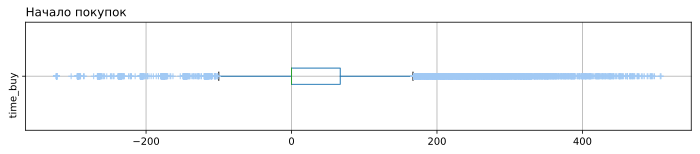

In [80]:
flierprops = dict(marker = '+', markeredgecolor = 'b')
medianprops = dict(linestyle = '-', linewidth = 1)

start_buy_bp.boxplot(column = 'time_buy', medianprops = medianprops, flierprops = flierprops,
                     vert = False, figsize = (12, 2), rot = 90)
plt.title('Начало покупок', loc = 'left')

plt.savefig('images/start_buy.png', bbox_inches = 'tight')
plt.show()

В основном люди покупают в первые несколько дней после перовго посещения сайта. Скорее всего перед посещением сайта люди уже примерно знают, куда хотят пойти, на сайте уточняют информацию о мероприятии, согласют её с друзьями/родственниками, с которыми собирались посетить это мероприятие, и покупают билеты.  
Много людей, которые совершили первую покупку больше, чем через полгода после первого посещения. Возможно, первый раз они зашли ради интереса, а когда уже захотелось посетить какое-то конкретное мероприятие, вспомнили, что можно купить билеты тут, и вернулись непосредственно за покупкой.  
Люди, купившие билеты до первого посещения сайта, скорее всего давно зарегистрировали почту на яндексе и делали покуки без необходимости посещать сам сайт афиши.

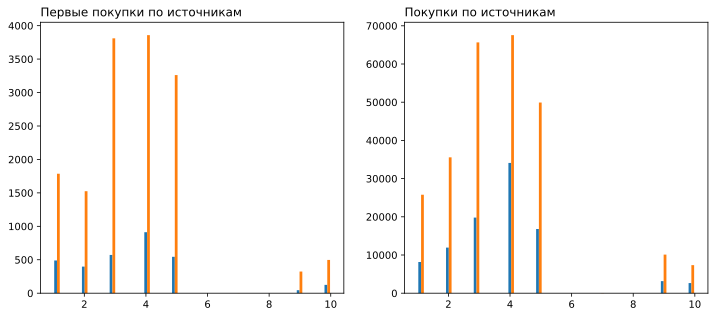

In [81]:
fig = plt.figure(figsize = (12, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))

temp = visits_orders.query('cumcount_buy == 0')

plt.hist([temp.query('device == "touch"')['source'], temp.query('device == "desktop"')['source']],
         bins = 40, label = ['touch', 'desktop'])
ax1.set_title('Первые покупки по источникам', loc = 'left')
ax1.set_xlabel('')
plt.savefig('images/first_pursheses_source.png', bbox_inches = 'tight')

ax2 = plt.subplot2grid((1, 2), (0, 1))
plt.hist([visits_orders.query('device == "touch"')['source'], visits_orders.query('device == "desktop"')['source']],
         bins = 40, label = ['touch', 'desktop'])

ax2.set_title('Покупки по источникам', loc = 'left')
ax2.set_xlabel('')

plt.show()

<a id="num_purchases"></a>
### Количество покупок за период

In [82]:
visits_orders.head(8)

uid       first_session               start  \
0  10000171586432207426 2017-01-12 15:11:00 2017-01-12 15:11:00   
1  10000344846682484395 2018-02-21 16:01:00 2018-02-21 16:01:00   
2   1000036778515242839 2017-05-09 20:22:00 2017-05-09 20:22:00   
3  10000460875579931334 2017-09-13 09:12:00 2017-09-13 09:12:00   
4  10000558740593440652 2018-03-01 18:39:00 2018-03-01 18:39:00   
5  10000584491997262943 2017-05-11 19:27:00 2017-05-11 19:27:00   
6  10000837700716403746                 NaT                 NaT   
7  10000837700716403746 2017-06-20 10:42:00 2017-06-20 10:42:00   

                  end  cumcount                 buy   device  source  revenue  \
0 2017-01-12 15:15:00       0.0                 NaT  desktop     3.0      NaN   
1 2018-02-21 16:36:00       0.0                 NaT  desktop     3.0      NaN   
2 2017-05-09 20:47:00       0.0                 NaT  desktop     3.0      NaN   
3 2017-09-13 09:23:00       0.0                 NaT    touch     4.0      NaN   
4 2018-03-01 19:00:00       0.0                 NaT  desktop     4.0      NaN   
5 2017-05-11 19:53:00       0.0                 NaT  desktop     4.0      NaN   
6                 NaT       NaN 2017-06-21 16:12:00     None     NaN      2.2   
7 2017-06-20 10:43:00       0.0                 NaT  desktop     1.0      NaN   

  cumcount_buy           first_buy        time_buy  
0                              NaT             NaT  
1                              NaT             NaT  
2                              NaT             NaT  
3                              NaT             NaT  
4                              NaT             NaT  
5                              NaT             NaT  
6            0 2017-06-21 16:12:00             NaT  
7              2017-06-21 16:12:00 1 days 05:30:00

In [83]:
visits_orders['buy_month'] = visits_orders['buy'].astype('datetime64[M]')
num_purshases = visits_orders.groupby(['buy_month', 'source']).agg({'buy': 'count', 'uid': 'nunique'})
num_purshases['mean_by_user'] = num_purshases['buy'] / num_purshases['uid']
num_purshases.reset_index(inplace = True)

In [84]:
num_purshases_total = visits_orders.groupby('buy_month').agg({'buy': 'count', 'uid': 'nunique'})
num_purshases_total.reset_index(inplace = True)

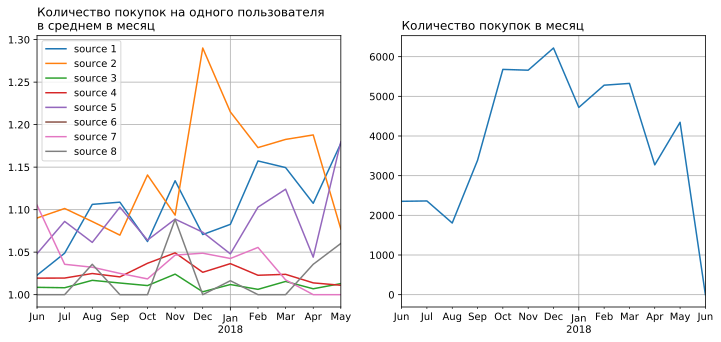

In [85]:
fig = plt.figure(figsize = (12, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))

num_purshases.groupby('source').plot('buy_month', 'mean_by_user', grid = True, ax = ax1, stacked = True)
ax1.legend(('source 1', 'source 2', 'source 3', 'source 4', 'source 5', 'source 6', 'source 7', 'source 8',
            'source 9', 'source 10'))
ax1.set_title('Количество покупок на одного пользователя\nв среднем в месяц', loc = 'left')
ax1.set_xlabel('')
plt.savefig('images/count_costs_source.png', bbox_inches = 'tight')

ax2 = plt.subplot2grid((1, 2), (0, 1))
num_purshases_total.plot('buy_month', 'buy', grid = True, legend = False, ax = ax2)

ax2.set_title('Количество покупок в месяц', loc = 'left')
ax2.set_xlabel('')

plt.show()

In [86]:
print ('Корреляция между количеством покупок и количеством уникальных пользователей за месяц: {:.2%}'.format(
       num_purshases['buy'].corr(num_purshases['uid'])))

Корреляция между количеством покупок и количеством уникальных пользователей за месяц: 99.63%


Данные о покупках представлены с июня 2017 по июнь 2018. Видимо, поэтому пользователей было больше в этот период.  
На одного человека приходится чуть больше одной покупки в месяц. Я считаю, это логично: не так много времени на досуг у людей в принципе. Летние выходные часто уходят на "грядки на даче", в декабре надо отвезти детей на ёлки, а это не дёшево. К тому же не так много мероприятий, которые вообще хотелось бы посетить каждому конкретному пользователю, и скорее всего, в силу свойственной человеку неорганизованности, половину интересных мероприятий люди просто пропустили, не узнав о них заранее.

Не думаю, что до июня 2017 и после июня 2018 ничего не покупали. Хотя, возможно, в июне 2017 и в июне 2018 на сайте произошли какие-то изменения, например в 2017 разместили много рекламы, а в 2018 изменили дизайн, что совпало с прекращением театрального периода, и пользователи пользовались другими сервисами для покупки билетов.

Пользователи, пришедшие из 1-3 источника в среднем совершают больше покупок, чем пользователи из оостальных источников.

<a id="avg_check"></a>
### Средний чек

In [87]:
print ('Средний чек одного покупателя в месяц: {:.2f}'
       .format(visits_orders.groupby(['buy_month', 'uid'])['revenue'].mean().mean()))

Средний чек одного покупателя в месяц: 4.31


In [88]:
revenue_source = visits_orders.groupby(['buy_month', 'source']).agg({'uid':'count', 'revenue':'sum'})
revenue_source.reset_index(inplace = True)
revenue_source['mean_revenue'] = revenue_source['revenue'] / revenue_source['uid']

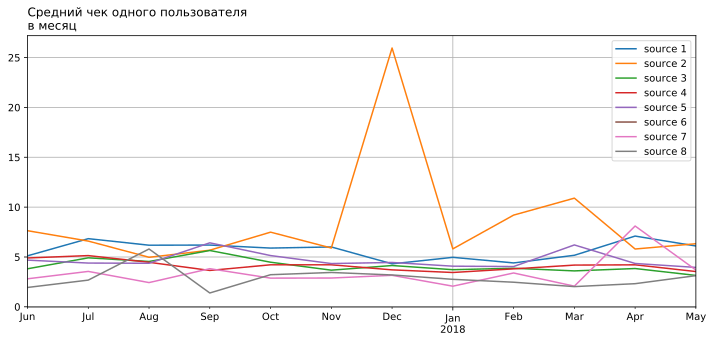

In [89]:
fig, ax = plt.subplots(figsize = (12, 5), sharey = True)

revenue_source.groupby('source').plot(x = 'buy_month', y = 'mean_revenue', grid = True, ax = ax)

plt.legend(('source 1', 'source 2', 'source 3', 'source 4', 'source 5', 'source 6', 'source 7', 'source 8',
            'source 9', 'source 10'))
plt.title('Средний чек одного пользователя\nв месяц', loc = 'left')

plt.xlabel('')

plt.savefig('images/mean_revenue_source.png', bbox_inches = 'tight')

plt.show()

In [90]:
revenue_source_month = revenue_source.groupby('source').agg({'uid':'sum', 'revenue':'sum'})
revenue_source_month.reset_index(inplace = True)
revenue_source_month['mean_revenue'] = revenue_source_month['revenue'] / revenue_source_month['uid']

In [91]:
print ('Средний чек одного покупателя в месяц по источникам:')
revenue_source_month

Средний чек одного покупателя в месяц по источникам:


source   uid   revenue  mean_revenue
0     1.0  3366  18819.31      5.591001
1     2.0  3068  28780.32      9.380808
2     3.0  4882  19722.77      4.039896
3     4.0  5538  22191.84      4.007194
4     5.0  4811  22750.52      4.728855
5     7.0     1      1.22      1.220000
6     9.0   559   1661.17      2.971682
7    10.0   684   1904.96      2.785029

Люди, пришедшие из второго источника, в среднем покупают более дорогие билеты или ходят на более дорогие мероприятия.  
6-10 источники приносят значительно меньше денег.

<a id="ltv"></a>
### LTV

В рамках этого проекта LTV считается как отношение выручки к числу пользователей.

In [92]:
print ('LTV =', visits_orders['revenue'].sum() / visits_orders['uid'].nunique())

LTV = 1.1046952039935312


<a id="costs"></a>
## Затраты

<a id="marketing"></a>
### Деньги на маркетинг

In [93]:
print ('Всего на все источники потрачено', costs['costs'].sum())

Всего на все источники потрачено 329131.62


In [94]:
costs_source = pd.DataFrame(costs.groupby('source_id')['costs'].sum()).reset_index()
print ('Затраты на каждый источник:')
costs_source

Затраты на каждый источник:


source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49

In [95]:
print ('Самый дорогой источник:',
       costs_source[costs_source['costs'] == costs_source['costs'].max()]['source_id'].sum())
print ('Самый дешёвый источник:',
       costs_source[costs_source['costs'] == costs_source['costs'].min()]['source_id'].sum())
print ('В среднем на один источник тратится:', costs_source['costs'].mean())

Самый дорогой источник: 3
Самый дешёвый источник: 9
В среднем на один источник тратится: 47018.80285714284


In [96]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [97]:
costs_month = pd.DataFrame(costs.groupby('month')['costs'].sum()).reset_index()
print ('Затраты в месяц:')
costs_month

Затраты в месяц:


month     costs
0  2017-06-01  18015.00
1  2017-07-01  18240.59
2  2017-08-01  14790.54
3  2017-09-01  24368.91
4  2017-10-01  36322.88
5  2017-11-01  37907.88
6  2017-12-01  38315.35
7  2018-01-01  33518.52
8  2018-02-01  32723.03
9  2018-03-01  30415.27
10 2018-04-01  22289.38
11 2018-05-01  22224.27

In [98]:
print ('Самый затратный месяц:',
       costs_month[costs_month['costs'] == costs_month['costs'].max()]['month'].iloc[0].date())
print ('Самый бюджетный месяц:',
       costs_month[costs_month['costs'] == costs_month['costs'].min()]['month'].iloc[0].date())
print ('В среднем в месяц тратится:', costs_month['costs'].mean())

Самый затратный месяц: 2017-12-01
Самый бюджетный месяц: 2017-08-01
В среднем в месяц тратится: 27427.634999999995


Логично не тратить много денег на привлечение новых покупателей в августе, перед началом театрального сезона.  
Возможно, много денег потрачено на маркетинг в декабре, потому что предложения о новогодних мероприятиях в это время года "сыпятся" ото всюду.

<a id="attraction"></a>
### Привлечение покупателей

In [99]:
visits_source = pd.DataFrame(visits.groupby('Source Id')['Uid'].nunique()).reset_index()

In [100]:
visits_source.rename(columns={'Source Id': 'source_id', 'Uid': 'count_uid'}, inplace = True)

In [101]:
visits_costs = pd.merge(visits_source, costs_source, on = 'source_id', how = 'outer')

In [102]:
visits_costs

source_id  count_uid      costs
0          1      18999   20833.27
1          2      26245   42806.04
2          3      74756  141321.63
3          4      83525   61073.60
4          5      56974   51757.10
5          6          6        NaN
6          7         34        NaN
7          9       9264    5517.49
8         10       8067    5822.49

Не хватает информации о 6, 7 и 8 источниках! Хотя привлечённые из них покупатели есть.  
Для того, чтобы понимать, сколько стоит превлечение одного покупателя из каждого источника, можно было бы взять среднее значение затрат на источник для 6 и 7 источников, но, как мы видим, из этих источников крайне мало людей пришло. Если взять средние затраты, то на эти 40 человек будет затрачено в разы больше, чем на 40 человек из любого другого источника. Думаю, в реальной ситуации об этом недостатке данных можно было бы уточнить у заказчика.

In [103]:
visits_costs['costs_per_user'] = visits_costs['costs'] / visits_costs['count_uid']

In [104]:
visits_costs

source_id  count_uid      costs  costs_per_user
0          1      18999   20833.27        1.096546
1          2      26245   42806.04        1.631017
2          3      74756  141321.63        1.890439
3          4      83525   61073.60        0.731201
4          5      56974   51757.10        0.908434
5          6          6        NaN             NaN
6          7         34        NaN             NaN
7          9       9264    5517.49        0.595584
8         10       8067    5822.49        0.721766

In [105]:
print ('В среднем привлечение одного покупателя стоит', visits_costs['costs_per_user'].mean())

В среднем привлечение одного покупателя стоит 1.0821409622003104


Но вспомним о том, что сущесвтует достаточное количество покупок, совершённых без визитов на сайт. Про этих пользователей неизвестно, из какого источника они пришли, следовательно, эти пользователи не вошли в рассчёт. Возможно, это и есть те самые 6, 7 и 8 источники =)

<a id="profit"></a>
### Чистая прибыль

In [106]:
print ('ROI = {:.2%}'.format((orders['Revenue'].sum() - costs['costs'].sum()) / costs['costs'].sum()))

ROI = -23.42%


Ушли в минус. Это крайне странно для такой корпорации. Хотя, возможно, нам не хватает каких-то данных, или это было сделано специально для бОльшей прибыли в будущем.

<a id="summary"></a>
# **Выводы**

**1. Проблемы в данных**  

Существуют записи о сессиях с нулевой и отрицательной длительностью.  
*Это затрудняет*
- *определение длительности сессий,*
- *определение времени, прошедшего с первого визита на сайт, до первой покупки,*
- *определение самой первой сессии.*  

Существуют покупки, совершённые вне сессий.  
*Это затрудняет*
- *определение времени, прошедшего с первого визита на сайт, до первой покупки,*
- *определение источника, с которого пришёл покупатель,*
- *определение устройства, с которого пользователь совершил покупку.*  

Несколько сессий может быть запущено одновременно, но нет пометок о том, в какой из них совершена покупка.  
*Это затрудняет*
- *определение источника, с которого пришёл покупатель,*
- *определение устройства, с которого пользователь совершил покупку,*
- *определение источника, после перехода с которого, пользователь совершил покупку.*

Данные о сессиях представлены с января 2017 по декабрь 2018, а данные о покупках с июня 2017 по июннь 2018.  
*Это искажает данные об оставшихся периодах (до июня 2017 и после июня 2018).*  

**2. Исследование данных**  

**Количество пользователей**
![](images/count_of_month_device.png)

<table>
      <tr>
          <th rowspan="2">устройство</th>
          <th colspan="2">в день</th>
          <th colspan="2">в неделю</th>
          <th colspan="2">в месяц</th>
      </tr>
      <tr>
          <th>все</th>
          <th>уникальные</th>
          <th>все</th>
          <th>уникальные</th>
          <th>все</th>
          <th>уникальные</th>
      </tr>
  <tr>
    <td>все</td>
    <td>548.938484</td><td>326.422031</td><td>4371.81</td><td>2281.69</td><td>12360.291667</td><td>9507.041667</td>
  </tr>
  <tr>
    <td>touch</td>
    <td>151.467811</td><td>96.500715</td><td>1273.46</td><td>676.75</td><td>3586.416667</td><td>2831.125000</td>
  </tr>
  <tr>
    <td>desktop</td>
    <td>399.294707</td><td>230.693848</td><td>3131.80</td><td>1614.78</td><td>8903.208333</td><td>6741.583333</td>
  </tr>
</table>

В 2017 наибольшее количество людей были на сайте с 6 по 12 числа каждого месяца, а в 2018 - с 1 по 5. Люди в основном пользуются сервисом в первые 10 дней каждого месяца. Скорее всего они выбирают несколько интересных им событий, планируя досуг на весь остаток месяца.  
Так как в данных о покупках нет для первой половины 2017 и второй половины 2018, можно предполагать, что и данные о пользователях в эти периоды искажены или неполные.  
Если рассматривать наиболее "полноценный" по данным год с июня 2017 по июнь 2018, то видно, что наибольшее количество пользователей было в конце ноября, когда люди планировали свой досуг на новогодние праздники. Также заметен приток пользователей в сентябре, когда начинается театральный сезон, и снижение количества пользователей в мае, когда театральный сезон окончен.  
Во вторую неделю месяца стабильно есть достаточное количество пользователей. Скорее всего в этих числах люди получают аванс и планируют куда бы им сходить в этом месяце.  
С компьютера люди заходят на сайт чаще, чем с телефона. Возможно, мобильная версия сайта не так удобна. А возможно, люди чаще посещают какие-либо культурные мероприятия не в одиночку, из-за чего обсуждать, куда сходить, удобнее с большого монитора компьютера.  

**Количество сессий**  

Среднее, наиболее вероятное, максимальное и минимальное количество сессий в день
в общем и для разных устройств:  

-|mean|	mode|	max|	date_max|	min|	date_min
-|-|-|-|-|-|-
all|	590.487840|	76.0	|4102|	24/11/2017|	57|	04/01/2018
touch|	158.622318|	16.0	|902	|24/11/2017	|13	|01/10/2017
desktop|431.865522|	62.0	|3200|	24/11/2017|	40|	04/01/2018

Наименьшее количество сессий было 04-01-2018: возможно, чтобы считать, что новогодние праздники прошли не зря, нужно именно 3 дня активного поиска досуга =)
В среднем, пользователи не начинают больше одной сессии в день. Те, кто начали больше одной сессии в день, скорее всего возвращаются, чтобы приобрести билет, изначально просто поискав мероприятия, на которые хотели бы сходить, либо на компьютере остаётся висеть открытая вкладка, а позже пользователь зашёл с телефона.

**Продолжительность сессий**  

Наиболее частая продолжительность сессии: 60 секунд  
Скорее всего люди узнают о мероприятиях из каких-то других источников: у знакомых, с рекламных плакатов в городе, из телепердач, - а на сайт заходят только для заказа билета.  

В среднем каждый пользователь начинал 1.57 сессий.  
Но существуют пользователи, которые начали 893 сессии.  
Чаще всего пользователь начинает 1 сессию и больше не возвращается.  

Если пользователи заходят на сайт только для заказа билета, а не для выбора мероприятия, но возвращаются немногие, возможно, в качестве инструмента приобритения билетов этот сайт не очень удобен. Возможно, где-то билеты дешевле.

**Покупки**  

Чаще всего пользователи совершают первую покупку через 1 минуту после того как впервые посетили сайт.  

![](images/start_buy.png)

В основном люди покупают в первые несколько дней после перовго посещения сайта. Скорее всего перед посещением сайта люди уже примерно знают, куда хотят пойти, на сайте уточняют информацию о мероприятии, согласют её с друзьями/родственниками, с которыми собирались посетить это мероприятие, и покупают билеты.
Много людей, которые совершили первую покупку больше, чем через полгода после первого посещения. Возможно, первый раз они зашли ради интереса, а когда уже захотелось посетить какое-то конкретное мероприятие, вспомнили, что можно купить билеты тут, и вернулись непосредственно за покупкой.
Люди, купившие билеты до первого посещения сайта, скорее всего давно зарегистрировали почту на яндексе и делали покуки без необходимости посещать сам сайт афиши.
На одного человека приходится чуть больше одной покупки в месяц. Улюдей не так много времени на досуг в принципе. Летние выходные часто уходят на "грядки на даче", в декабре надо отвезти детей на ёлки, а это не дёшево. К тому же не так много мероприятий, которые вообще хотелось бы посетить каждому конкретному пользователю, и скорее всего, в силу свойственной человеку неорганизованности, половину интересных мероприятий люди просто пропустили, не узнав о них заранее.  

![](images/first_pursheses_source.png)

С телефона и с компьютера больше всего пользователи начинают покупать перейдя из 4 источника, но для пользователей ПК 3 источник почти так же удобен как и 4, чего не скажешь о покупках с телефонов. Для них одинаковы 3 и 5 источники.

**Источники**  
![](images/count_costs_source.png)
Средний чек одного покупателя в месяц по источникам:

source|	uid|	revenue|	mean_revenue
-|-|-|-
1|	3366|	18819.31|	5.591001
2|	3068|	28780.32|	9.380808
3|	4882|	19722.77|	4.039896
4|	5538|	22191.84|	4.007194
5|	4811|	22750.52|	4.728855
7|	1	|1.22	|1.220000
9|	559	|1661.17|	2.971682
10|	684	|1904.96|	2.785029

В августе и сентябре 2017 из 3 источника было больше всего пользователей, а в остальное время самым "популярным" источником был 4. Что это за источники неизвестно, поэтому предположить, почему так сложилось, невозможно, но по всем месяцам видно, что больше всего пользователей приходят из 3, 4 и 5 источников, а вот на 6, 7 и 8 деньги можно не тратить.  
Пользователи, пришедшие из 1-3 источника в среднем совершают больше покупок, чем пользователи из оостальных источников.  
Люди, пришедшие из второго источника, в среднем покупают более дорогие билеты или ходят на более дорогие мероприятия.
6-10 источники приносят значительно меньше денег.  

Затраты на каждый источник:

source_id	|costs
-|-
1	|20833.27
2	|42806.04
3	|141321.63
4	|61073.60
5	|51757.10
9	|5517.49
10|	5822.49
Всего| 329131.62


**3. Метрики**  

DAU (количество уникальных пользователей в день): 905.5013698630137  
WAU (количество уникальных пользователей в неделю): 4386.802816901409  
MAU (количество уникальных пользователей в месяц): 12300.958333333334  

ASL (средняя продолжительность сессии): 60 секунд  

LTV (ценность пользователя): 1.1046952039935312  

В среднем привлечение одного покупателя стоит 1.0821409622003104  
ROI (чистая прибыль): -23.42%  

**4. Выводы**  

На 6-10 источники деньги можно не тратить - из них мало пользователей приходят и совершают мало покупок.  

Больше всего пользователей в театральный сезон и особенно много в конце ноября.

83.99% пользователей вообще не совершили покупок.  
Думаю, что с процессом непосредственной покупки всё в порядке, но чтобы увеличить их количество, нужно улучшить сам сайт. То есть сделать упор на удобство пользования до покупки, чтобы люди больше пользовались сайтом не только для покупки, но и для выбора мероприятий.  
Есть личный аккаунт, я могу отметить понравившиеся мероприятия, но не могу заранее выбрать класс мероприятий, о которых хотела бы быть в курсе, например, выставки. Также не могу выбрать диапазон цен при выборе мероприятия. Удобно, что всё в одном месте, но получается, что для каждого вида отдыха (кино, концерты, театры) существуют другие специализированные сервисы. Если человек хочет в кино, он смотрит, что сейчас идёт в ближайшем кинотеатре или в любимом кинотеатре и выбирает фильм и билет там, если он хочет посмотреть конкретный фильм, который в кино не идёт, но может показываться в антикафе, на открытом воздухе или в ночь кино на подобных площадках, он ищет этот конкретный фильм - ему нет смысла заходить на сайт яндекс.афиши. Если человек любит ходить в театр, скорее всего у него есть любимые театры, у которых есть свои сайты, он в курсе их репертуара и, опять-таки, ему нет смысла покупать билет на яндекс.афише. То же касается музыкальных концертов. Люди не ходят "просто на какой-нибудь концерт", у них есть любимые исполнители, любимые жанры, то есть раздел концерты остаётся тем, у кого нет любимых исполнителей, но захотелось послушать, например, джаз, а про конкретные концерты конкретных исполнителей люди скорее всего уже в курсе из других источников.  То есть я бы предложила реализовать возможность указать предпочтения заранее, иначе бОльшая часть аудитории это люди, которые хотят культурного мероприятия в самом широком смысле слова, но такие скорее всего будут долго листать ленту мероприятий, но так никуда и не соберуться =) Мне было бы удобно помимо отметок того, что мне понравилось, указать, за чем бы я хотела следить, например, несколько исполнителей, несколько хобби, на мастер-классы по которым я бы пошла, несколько художников/площадок/жанров выставок, тогда, возможно, я бы чаще покупала билеты. И, мне кажется, было бы удобно, если бы Яндекс использовал информацию из аккаунта по соглашению пользователя: у меня есть подписка, яндекс знает все оценки фильмов на кинопоиске, все предпочтения в музыке, где я чаще всего бываю (из карт), то есть достаточно информации, чтобы показать мне то, что я с большой вероятностью хочу и могу посетить.  
Также стоит учесть, что с телефона на сайт заходит очень мало пользователей по сравнению с ПК, но в целом решение вопроса "куда пойти" решается именно с телефонов: люди просто вбивают в поиск интересующие их мероприятия рядом с ними, пока сидят с друзьями в кафе, а кофе уже допивают. Так что было бы логично сделать мобильное приложение, но оно есть только для пользователей iPhone =(